## Import

In [1]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# NUM_FEATURES = 31
# TIMESTEPS = 1
# DATASET_LINK = "dataset/overall.csv"
# TEST_DATA_LINK = "dataset/overall_test.csv"

NUM_FEATURES = 3
TIMESTEPS = 1
DATASET_LINK = "dataset/5000_overall.csv"
TEST_DATA_LINK = "dataset/5000_overall_test.csv"

# random seed for reproducibility
SEED = 123

### LOAD DATASET
> * Check for class imbalance

In [3]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,Hold,Down-Down,Up-Down
0,Andy,1,1,0.142176,0.156880,0.014704
1,Andy,1,2,0.141793,0.164635,0.022842
2,Andy,1,3,0.157152,0.147220,-0.009932
3,Andy,1,4,0.158673,0.142487,-0.016186
4,Andy,1,5,0.166583,0.157102,-0.009480


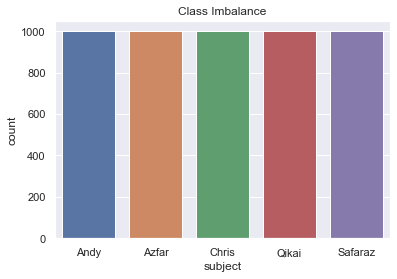

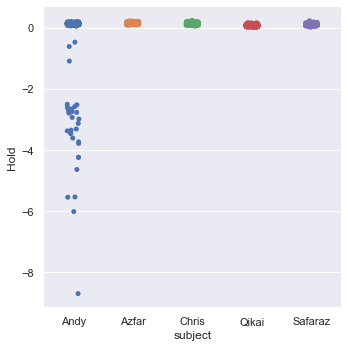

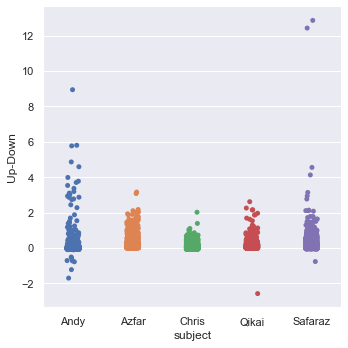

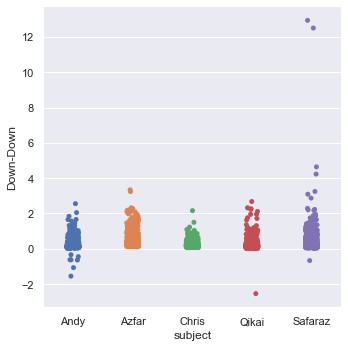

In [4]:
#################################
# # check for class imbalance # #
#################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

# sns.catplot(x="subject", y="H.period", data=df)

sns.catplot(x="subject", y="Hold", data=df)
sns.catplot(x="subject", y="Up-Down", data=df)
sns.catplot(x="subject", y="Down-Down", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [5]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to one hot encoded Y for model
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

#################################
# # get all the encoded class # #
#################################
print("Encoder is able to decipher: ")
print(encoder.get_feature_names_out())
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

Encoder is able to decipher: 
['x0_Andy' 'x0_Azfar' 'x0_Chris' 'x0_Qikai' 'x0_Safaraz']


X dataset shape: (5000, 3)
Y dataset shape: (5000, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [6]:
# split dataset into train and test of 0.8/0.2 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)

# normalisation to 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
num_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (4000, 1, 3)
Y train shape: (4000, 5)
X test shape: (1000, 1, 3)
Y test shape: (1000, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [7]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=512, return_sequences=True, 
                 input_shape=(TIMESTEPS,NUM_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=1000, 
                            batch_size=36)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable kfold validation

In [8]:
# from sklearn.model_selection import LeaveOneOut
# def evaluate_kfold(model, X_train, y_train, SEED):
    
#     # evaluate the model
#     model = create_model()
#     scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
#     ideal, _, _ = mean(scores), scores.min(), scores.max()
#     print('Ideal: %.3f' % ideal)
    
#     folds = range(2,31)
#     means, mins, maxs = list(), list(), list()
    
#     # evaluate each k value
#     for k in folds:
#         # define the test condition
#         kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
#         # evaluate k value
#         model = create_model()
#         scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
#         print(scores)
#         k_mean = np.mean(scores)
#         k_min = scores.min()
#         k_max = scores.max()
        
#         # report performance
#         print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
#               (k, k_mean*100, k_min*100, k_max*100))
        
#         # store mean accuracy
#         means.append(k_mean)
        
#         # store min and max relative to the mean
#         mins.append(k_mean - k_min)
#         maxs.append(k_max - k_mean)
        
#     # line plot of k mean values with min/max error bars
#     pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
#     # plot the ideal case in a separate color
#     pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
#     # show the plot
#     pyplot.show()
    
# evaluate_kfold(model, X_train, y_train, SEED)

In [9]:
# ##################################################
# # # evaluate kfold model for accuracy and loss # #
# ##################################################
# def evaluate_kfold_model(X_train, y_train, SEED):
#     scores, histories = list(), list()
#     # create model
#     model = create_model()
#     # prepare cross validation
#     kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
#     # enumerate splits
#     for train_ix, test_ix in kfold.split(X_train):
#         # select rows for train and test
#         trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
#         # fit model
#         history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
#         # evaluate model
#         y_pred = model.predict(testX)
#         y_pred = to_categorical(y_pred)

#         # evaluate predictions
#         acc = accuracy_score(testY, y_pred)
#         print("Testing accuracy: %.3f%%" % (acc*100))

#         # stores scores and histories
#         scores.append(acc)
#         histories.append(history)

#     for i in range(len(histories)):
#         # plot loss
#         f1 = plt.figure(1)
#         plt.title('Categorical Cross-Entropy Loss')
#         plt.plot(histories[i].history['loss'], color='blue')
#         plt.plot(histories[i].history['val_loss'], color='orange')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')

#         # plot accuracy
#         f2 = plt.figure(2)
#         plt.title('Classification Accuracy')
#         plt.plot(histories[i].history['accuracy'], color='blue')
#         plt.plot(histories[i].history['val_accuracy'], color='orange')
#         plt.ylabel('accuracy')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='lower right')

#     # print summary
#     print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
#     # box and whisker plots of results
#     f3 = plt.figure(3)
#     plt.title('Box and Whisker Plot of Accuracy Scores')
#     plt.ylabel('accuracy')
#     plt.xlabel('model')
#     plt.boxplot(scores)
#     plt.show()
    
# evaluate_kfold_model(X_train, y_train, SEED)

##### Perform actual KFold Validation

In [ ]:
# create model
model = create_model()

num_folds = 2
kfold = KFold(n_splits=num_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/1000
56/56 [==============================] - 6s 14ms/step - loss: 2.0267 - accuracy: 0.1965
Epoch 2/1000
56/56 [==============================] - 1s 14ms/step - loss: 1.8384 - accuracy: 0.2195
Epoch 3/1000
56/56 [==============================] - 1s 14ms/step - loss: 1.7980 - accuracy: 0.2095
Epoch 4/1000
56/56 [==============================] - 1s 15ms/step - loss: 1.7650 - accuracy: 0.2240
Epoch 5/1000
56/56 [==============================] - 1s 15ms/step - loss: 1.7606 - accuracy: 0.1955
Epoch 6/1000
56/56 [==============================] - 1s 14ms/step - loss: 1.7072 - accuracy: 0.2265
Epoch 7/1000
56/56 [==============================] - 1s 15ms/step - loss: 1.6913 - accuracy: 0.2225
Epoch 8/1000
56/56 [==============================] - 1s 17ms/step - loss: 1.6810 - accuracy: 0.2220
Epoch 9/1000
56/56 [==============================] - 1s 20ms/step - loss: 1.6774 - accuracy: 0.2160
Epoch 10/1000
56/56 [==============================] - 1s 20ms/step - loss: 1.6761 - accura

##### Get Validation Accuracy

In [ ]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

### MODEL FITTING
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [ ]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X_train, y_train, callbacks=es)

In [ ]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
##########################
# # view model summary # #
##########################
model.model.summary()

### MODEL TESTING
> * get model accuracy on the test dataset
> * save the model if appropriate

In [ ]:
y_pred = model.predict(X_test)
y_pred = to_categorical(y_pred)

# evaluate predictions
acc = accuracy_score(y_test, y_pred)
print("Testing accuracy: %.3f%%" % (acc*100))

In [ ]:
##################
# # save model # #
##################

model.model.save("model/key_classifier.h5")

###########################
# # save model in colab # #
###########################

# model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LOAD MODEL

In [ ]:
##################
# # load model # #
##################

model.model = load_model("model/key_classifier.h5")

###########################
# # load model in colab # #
###########################

# model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [ ]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

In [ ]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
df = df.dropna()

In [ ]:
pred_dataset = pred_df.values

# divide data into features X
# X_new = new_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[0:2,3:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_row.shape[0], TIMESTEPS, pred_arr.shape[1]))

In [ ]:
####################################
# # get prediction and its label # #
####################################

pred = model.predict(pred_arr)
pred = to_categorical(pred)
pred = encoder.inverse_transform(pred)
pred = np.ravel(pred)

pred_proba = model.predict_proba(pred_arr)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)